In [1]:
import numpy as np
import numpy.linalg as la
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from math import sqrt


import warnings
warnings.filterwarnings("error")

In [2]:
# Network parameters
agent_num = 10
d = 4

# Parameters for functions
a = np.random.randn(agent_num , d )
b = np.random.randn(agent_num , d )

b[agent_num-1,:] = -np.sum(b[:-1,:], axis=0)

# print(-np.sum(b[:-2,:], axis=0))
# print(b[:-1,:])
# print(b)
# print(np.sum(b, axis=0))

In [397]:
averaging_matrix = np.ones((agent_num, agent_num))/agent_num

mix_weight = 0.1
mixing_matrix = np.eye(agent_num) *(1 - 2*mix_weight)
for i in range(agent_num):
    mixing_matrix[i,(i+1)%agent_num] = mixing_matrix[i,(i-1)%agent_num] = mix_weight
# print(mixing_matrix)


In [207]:
def global_function_case_3(x, a, b):
    x = x+2
    agent_num = a.shape[0]
    m = 12
    if a.shape != b.shape or a.shape[1]!=x.shape[0]:
        print("variable size error!")
    function_val = 0
    for i in range(agent_num):
        ax = np.dot(a[i], x)
        bx = np.dot(b[i], x)
        if(np.abs(ax)<=1):
            function_val += (1/m*ax**m+bx)
        else:
            function_val += (np.abs(ax) + bx - (m-1)/m)
    return function_val/agent_num
            
def function_gradient_case_3(x, a, b):
    
    x = x+2
    agent_num = a.shape[0]
    m = 12
    if a.shape != b.shape or a.shape!=x.shape:
        print("variable size error!")
    gradient = np.zeros(x.shape)
    for i in range(agent_num):
        ax = np.dot(a[i], x[i])
        bx = np.dot(b[i], x[i])
        if(np.abs(ax)<=1):
            gradient[i] = ((ax**(m-1))*a[i]+b[i])
        else:
            gradient[i] = (np.sign(ax)*a[i]+b[i])
    return gradient

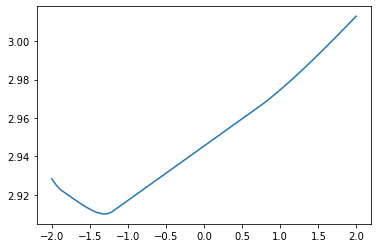

In [208]:
# See if the function is correct

x_base = np.linspace(-2,2,1000, endpoint=False)
func_val = np.zeros((1000))
x_real = np.random.randn(d)
for i in range(1000):
    x_real[0] = x_base[i]
    func_val[i] = global_function_case_3(x_real, a, b)

plt.plot(x_base, func_val)

In [211]:
x_star = np.zeros(d)
loss_star = global_function_case_3(x_star, a, b)
print(loss_star)

loss_star = 0

2.237680614485955


In [304]:
#start the algorithm, this block is normal dgd
x_0 = np.random.rand(agent_num, d)

#first is gradient Descent
iter_num = 100000
lr = 0.1
time_int = 0.01

x_k = np.zeros((agent_num,d))
x_k1 = np.zeros((agent_num,d))

z_k = np.zeros((agent_num,d))
z_k1 = np.zeros((agent_num,d))
# x_k2 = np.zeros((agent_num,d))
y_k = np.zeros((agent_num,d))
y_k1 = np.zeros((agent_num,d))

DGD_x_mean = np.zeros((iter_num,d))

DGD_x_dist = np.zeros((iter_num, agent_num))

DGD_loss_x_global = np.zeros((iter_num, agent_num))

lambda_0 = 0
lambda_k = 0
lambda_k1 = 0

# simulation centralized
for agent in range(agent_num):
    x_k[agent,:] = np.mean(x_0, axis=0)
#

# x_k = np.copy(x_0)
z_k =  np.copy(x_k)

lambda_k = lambda_0
for k in tqdm(range( iter_num)):
    # print(x_k)
    lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
    gamma = (1-lambda_k)/(lambda_k1)
    lambda_k = lambda_k1
    gradient_all = function_gradient_case_3(x_k, a, b) 
    
    gradient_avg =  np.mean(gradient_all, axis=0)
    for i in range(agent_num):
        y_k1[i,:] = y_k[i,:] + time_int*(x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:])
        # z_k1[i,:] = x_k[i,:] - time_int*(lr*gradient_all[i,:] - y_k[i,:] - (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]))
        # z_k1[i,:] = x_k[i,:] - time_int*(lr*gradient_avg - y_k[i,:] - (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]))
        z_k1[i,:] = x_k[i,:] - time_int*(lr*gradient_all[i,:] )
        # x_k1[i,:] = z_k1[i,:]
        x_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_k1[i,:] - z_k[i,:]) 
        # x_k1[i,:] = (1-gamma)*z_k1[i,:] + gamma*z_k[i,:]
    z_k = np.copy(z_k1)
    x_k = np.copy(x_k1)
    y_k = np.copy(y_k1)
    
    
    x_bar = np.mean(x_k, axis=0)
    
    for agent in range(agent_num):
        x_k[agent,:] = x_bar
        
    DGD_x_mean[k,:] = x_bar
    for agent in range(agent_num):
        
        DGD_x_dist[k, agent] = np.linalg.norm(x_k[agent,:]-x_bar)
        DGD_loss_x_global[k, agent] = global_function_case_3(x_k[agent,:], a, b)
        # print(x_k)
        # print(global_function_case_3(x_k[agent,:], a, b))
        # input()
    
    

  0%|          | 0/100000 [00:00<?, ?it/s]

In [243]:
# #start the algorithm, this block is normal dgd
# x_0 = np.random.rand(agent_num, d)

# #first is gradient Descent
# iter_num = 100000
# lr = 0.1
# time_int = 0.01

# x_k = np.zeros((agent_num,d))
# x_k1 = np.zeros((agent_num,d))

# z_k = np.zeros((agent_num,d))
# z_k1 = np.zeros((agent_num,d))
# # x_k2 = np.zeros((agent_num,d))
# y_k = np.zeros((agent_num,d))
# y_k1 = np.zeros((agent_num,d))

# DGD_x_mean = np.zeros((iter_num,d))

# DGD_x_dist = np.zeros((iter_num, agent_num))

# DGD_loss_x_global = np.zeros((iter_num, agent_num))

# lambda_0 = 0
# lambda_k = 0
# lambda_k1 = 0

# # simulation centralized
# for agent in range(agent_num):
#     x_k[agent,:] = np.mean(x_0, axis=0)
# #

# # x_k = np.copy(x_0)
# z_k =  np.copy(x_k)

# lambda_k = lambda_0
# for k in tqdm(range( iter_num)):
#     lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
#     gamma = (1-lambda_k)/(lambda_k1)
#     lambda_k = lambda_k1
#     gradient_all = function_gradient_case_3(x_k, a, b) 
    
#     gradient_avg =  np.mean(gradient_all, axis=0)
#     for i in range(agent_num):
#         y_k1[i,:] = y_k[i,:] + time_int*(x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:])
#         z_k1[i,:] = x_k[i,:] - time_int*(lr*gradient_avg - y_k[i,:] - (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]))
#         x_k1[i,:] = z_k1[i,:]
#         # x_k1[i,:] = (1-gamma)*z_k1[i,:] + gamma*z_k[i,:]
#     z_k = np.copy(z_k1)
#     x_k = np.copy(x_k1)
#     y_k = np.copy(y_k1)
    
#     x_bar = np.mean(x_k, axis=0)
    
#     DGD_x_mean[k,:] = x_bar
#     for agent in range(agent_num):
        
#         DGD_x_dist[k, agent] = np.linalg.norm(x_k[agent,:]-x_bar)
#         DGD_loss_x_global[k, agent] = global_function_case_3(x_k[agent,:], a, b)
    
    

In [334]:
#start the algorithm
x_0 = np.random.rand(agent_num, d)

#first is gradient Descent
iter_num = 100000
lr = 0.1
time_int = 0.1
s = time_int
sqrt_s = np.sqrt(s)

x_k = np.zeros((agent_num,d))
x_k1 = np.zeros((agent_num,d))

z_k = np.zeros((agent_num,d))
z_k1 = np.zeros((agent_num,d))
# x_k2 = np.zeros((agent_num,d))
y_k = np.zeros((agent_num,d))
y_k1 = np.zeros((agent_num,d))

x_mean = np.zeros((iter_num,d))
x_dist = np.zeros((iter_num, agent_num))
loss_x_global = np.zeros((iter_num, agent_num))

lambda_0 = 0
lambda_k = 0
lambda_k1 = 0

x_k = np.copy(x_0)
z_k =  np.copy(x_k)

lambda_k = lambda_0
for k in tqdm(range( iter_num)):
    lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
    gamma = (1-lambda_k)/(lambda_k1)
    lambda_k = lambda_k1
    gradient_all = function_gradient_case_3(x_k, a, b)
    # gradient_all = np.zeros(z_k.shape)
    for i in range(agent_num):
        y_k1[i,:] = y_k[i,:] + s*(1/agent_num)*(2*z_k[i,:]-z_k[(i+1)%agent_num,:]-z_k[(i-1)%agent_num,:] )
        # z_k1[i,:] = x_k[i,:] - s*(lr*gradient_all[i,:] +  y_k[i,:]+ (1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]+z_k[(i-1)%agent_num,:] ))
        z_k1[i,:] = x_k[i,:] - s*(lr*gradient_all[i,:] +  y_k[i,:]+ 10*(1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]-z_k[(i-1)%agent_num,:] ))
        # x_k1[i,:] = z_k1[i,:]
        # x_k1[i,:] = (1-gamma)*z_k1[i,:] + gamma*z_k[i,:] #-  time_int*(0- (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]) )
        z_diff = z_k1 - z_k
        x_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_diff[i,:]) -  10*sqrt_s*(1/agent_num)*( 2*z_diff[i,:]-z_diff[(i-1)%agent_num,:] -z_diff[(i+1)%agent_num,:] ) #z_k1[i,:] + (1 - (3/(k+1)) )*(z_diff[i,:]) 
        
        # z_bar = np.mean(z_k, axis=0)
        # z1_bar = np.mean(z_k1, axis=0)
        # x_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_k1[i,:] - z_k[i,:]) -  2*sqrt_s*(z_k1[i,:] - z_k[i,:])
        # x_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_k1[i,:] - z_k[i,:]) -  2*sqrt_s*(z_k1[i,:] - z_k[i,:])
        # x_k1[i,:] = z_k1[i,:] -gamma*(z_k1[i,:] - z_k[i,:]) +  time_int*( (z_k1[(i-1)%agent_num,:] - z_k[(i-1)%agent_num,:]+z_k1[(i+1)%agent_num,:] - z_k[(i+1)%agent_num,:] - 2*(z_k1[i,:] - z_k[i,:])) )
    z_k = np.copy(z_k1)
    x_k = np.copy(x_k1)
    y_k = np.copy(y_k1)
    
    x_bar = np.mean(x_k, axis=0)
    x_mean[k,:] = x_bar
    for agent in range(agent_num):
        x_dist[k, agent] = np.linalg.norm(x_k[agent,:]-x_bar)
        loss_x_global[k, agent] = global_function_case_3(x_k[agent,:], a, b)
        
        
        
    
    

  0%|          | 0/100000 [00:00<?, ?it/s]

In [442]:
#testing



x_0 = np.random.rand(agent_num, d)

#first is gradient Descent
iter_num = 100000
lr = 0.1
time_int = 0.01
s = time_int
sqrt_s = np.sqrt(s)

x_k = np.zeros((agent_num,d))
x_k1 = np.zeros((agent_num,d))

z_k = np.zeros((agent_num,d))
z_k1 = np.zeros((agent_num,d))
# x_k2 = np.zeros((agent_num,d))
y_k = np.zeros((agent_num,d))
y_k1 = np.zeros((agent_num,d))

w_k = np.zeros((agent_num,d))
w_k1 = np.zeros((agent_num,d))

x_mean = np.zeros((iter_num,d))
x_dist = np.zeros((iter_num, agent_num))
loss_x_global = np.zeros((iter_num, agent_num))

lambda_0 = 0
lambda_k = 0
lambda_k1 = 0

x_k = np.copy(x_0)
z_k =  np.copy(x_k)

lambda_k = lambda_0
for k in tqdm(range( iter_num)):
    lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
    gamma = (1-lambda_k)/(lambda_k1)
    lambda_k = lambda_k1
    gradient_all = function_gradient_case_3(x_k, a, b)
    
    # gradient_all = averaging_matrix@gradient_all
    # gradient_all = np.zeros(z_k.shape)
    for i in range(agent_num):
        y_k1[i,:] = y_k[i,:] + s*(1/agent_num)*(2*x_k[i,:]-x_k[(i+1)%agent_num,:]-x_k[(i-1)%agent_num,:] )
        # z_k1[i,:] = x_k[i,:] - s*(lr*gradient_all[i,:] +  y_k[i,:]+ (1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]+z_k[(i-1)%agent_num,:] ))
    # y_k1 = averaging_matrix@y_k1
    for i in range(agent_num):
        z_k1[i,:] = x_k[i,:] - s*(lr*gradient_all[i,:] +  y_k[i,:]+ 10*(1/agent_num)*(2*x_k[i,:] - x_k[(i+1)%agent_num,:]-x_k[(i-1)%agent_num,:] ))
        # x_k1[i,:] = z_k1[i,:]
        # x_k1[i,:] = (1-gamma)*z_k1[i,:] + gamma*z_k[i,:] #-  time_int*(0- (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]) )
    for i in range(agent_num):

        z_diff = z_k1 - z_k
        w_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_diff[i,:]) -  10*sqrt_s*(1/agent_num)*( 2*z_diff[i,:]-z_diff[(i-1)%agent_num,:] -z_diff[(i+1)%agent_num,:] ) #z_k1[i,:] + (1 - (3/(k+1)) )*(z_diff[i,:]) 
        
        
    for i in range(agent_num):
        x_k1[i,:] = w_k1[i,:] #- s* (2*w_k1[i,:]-w_k1[(i+1)%agent_num,:]-w_k1[(i-1)%agent_num,:])
    # x_k1 = mixing_matrix@x_k1
        # z_bar = np.mean(z_k, axis=0)
        # z1_bar = np.mean(z_k1, axis=0)
        # x_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_k1[i,:] - z_k[i,:]) -  2*sqrt_s*(z_k1[i,:] - z_k[i,:])
        # x_k1[i,:] = z_k1[i,:] + (1 - (3/(k+1)) )*(z_k1[i,:] - z_k[i,:]) -  2*sqrt_s*(z_k1[i,:] - z_k[i,:])
        # x_k1[i,:] = z_k1[i,:] -gamma*(z_k1[i,:] - z_k[i,:]) +  time_int*( (z_k1[(i-1)%agent_num,:] - z_k[(i-1)%agent_num,:]+z_k1[(i+1)%agent_num,:] - z_k[(i+1)%agent_num,:] - 2*(z_k1[i,:] - z_k[i,:])) )
    z_k = np.copy(z_k1)
    x_k = np.copy(x_k1)
    y_k = np.copy(y_k1)
    w_k = np.copy(w_k1)
    
    
    
    
    x_bar = np.mean(x_k, axis=0)
    x_mean[k,:] = x_bar
    for agent in range(agent_num):
        x_dist[k, agent] = np.linalg.norm(x_k[agent,:]-x_bar)
        loss_x_global[k, agent] = global_function_case_3(x_k[agent,:], a, b)
        
        
        
    
    

  0%|          | 0/100000 [00:00<?, ?it/s]

In [474]:
#inplementing na li's formulation



x_0 = np.random.rand(agent_num, d)

#first is gradient Descent
iter_num = 100000
lr = 0.1
time_int = 0.01
s = time_int
sqrt_s = np.sqrt(s)

eta_t = 0.01

x_k = np.zeros((agent_num,d))
x_k1 = np.zeros((agent_num,d))

v_k = np.zeros((agent_num,d))
v_k1 = np.zeros((agent_num,d))
# x_k2 = np.zeros((agent_num,d))
y_k = np.zeros((agent_num,d))
y_k1 = np.zeros((agent_num,d))

s_k = np.zeros((agent_num,d))
s_k1 = np.zeros((agent_num,d))

na_x_mean = np.zeros((iter_num,d))
na_x_dist = np.zeros((iter_num, agent_num))
na_loss_x_global = np.zeros((iter_num, agent_num))

alpha_0 = 0.5
alpha_k = alpha_0
alpha_k1 = (-alpha_k**2 + alpha_k*np.sqrt(alpha_k**2 +4))/2

s_k = function_gradient_case_3(x_k, a, b)

# x_k = np.copy(x_0)
# z_k =  np.copy(x_k)

lambda_k = lambda_0
for k in tqdm(range( iter_num)):
    alpha_k1 = (-alpha_k**2 + alpha_k*np.sqrt(alpha_k**2 +4))/2

    # lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
    # gamma = (1-lambda_k)/(lambda_k1)
    # lambda_k = lambda_k1
    
    
    x_k1 = mixing_matrix@y_k - eta_t*s_k
    v_k1 = mixing_matrix@v_k - eta_t/alpha_k*s_k
    y_k1 = (1 - alpha_k1)*x_k1 + alpha_k1 * v_k1
    
    gradient_last = function_gradient_case_3(y_k, a, b)
    gradient_new = function_gradient_case_3(y_k1, a, b)
    
    s_k1 = mixing_matrix@s_k + (gradient_new - gradient_last)


    s_k = np.copy(s_k1)
    x_k = np.copy(x_k1)
    y_k = np.copy(y_k1)
    v_k = np.copy(v_k1)
    alpha_k = alpha_k1
    
    
    
    x_bar = np.mean(x_k, axis=0)
    na_x_mean[k,:] = x_bar
    for agent in range(agent_num):
        na_x_dist[k, agent] = np.linalg.norm(x_k[agent,:]-x_bar)
        na_loss_x_global[k, agent] = global_function_case_3(x_k[agent,:], a, b)
        
        
        
    
    

  0%|          | 0/100000 [00:00<?, ?it/s]

In [475]:
#inplementing Lin & Li's formulation



x_0 = np.random.rand(agent_num, d)

#first is gradient Descent
iter_num = 100000
lr = 0.1
time_int = 0.01
s = time_int
sqrt_s = np.sqrt(s)

eta_t = 0.01

x_k = np.zeros((agent_num,d))
x_k1 = np.zeros((agent_num,d))

z_k = np.zeros((agent_num,d))
z_k1 = np.zeros((agent_num,d))
# x_k2 = np.zeros((agent_num,d))
y_k = np.zeros((agent_num,d))
y_k1 = np.zeros((agent_num,d))

s_k = np.zeros((agent_num,d))
s_k1 = np.zeros((agent_num,d))

lin_x_mean = np.zeros((iter_num,d))
lin_x_dist = np.zeros((iter_num, agent_num))
lin_loss_x_global = np.zeros((iter_num, agent_num))

alpha_0 = 0.5
alpha_k = alpha_0
alpha_k1 = (-alpha_k**2 + alpha_k*np.sqrt(alpha_k**2 +4))/2

s_k = function_gradient_case_3(x_k, a, b)

# x_k = np.copy(x_0)
# z_k =  np.copy(x_k)

lambda_k = lambda_0
for k in tqdm(range( iter_num)):
    alpha_k1 = (-alpha_k**2 + alpha_k*np.sqrt(alpha_k**2 +4))/2

    # lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
    # gamma = (1-lambda_k)/(lambda_k1)
    # lambda_k = lambda_k1
    
    y_k1 = alpha_k* z_k + (1 - alpha_k)*x_k
    
    gradient_last = function_gradient_case_3(y_k, a, b)
    gradient_new = function_gradient_case_3(y_k1, a, b)    
    
    s_k1 = mixing_matrix@s_k + (gradient_new - gradient_last)
    z_k1 = mixing_matrix@z_k - (eta_t/alpha_k)*s_k1
    x_k1 = alpha_k * z_k1 + (1 - alpha_k)*mixing_matrix@x_k
    
#     x_k1 = mixing_matrix@y_k - eta_t*s_k
#     v_k1 = mixing_matrix@v_k - eta_t/alpha_k*s_k
#     y_k1 = (1 - alpha_k1)*x_k1 + alpha_k1 * v_k1
    
    alpha_k = alpha_k1
    
#     s_k1 = mixing_matrix@s_k + (gradient_new - gradient_last)


    s_k = np.copy(s_k1)
    x_k = np.copy(x_k1)
    y_k = np.copy(y_k1)
    z_k = np.copy(z_k1)
    
    
    
    
    x_bar = np.mean(x_k, axis=0)
    lin_x_mean[k,:] = x_bar
    for agent in range(agent_num):
        lin_x_dist[k, agent] = np.linalg.norm(x_k[agent,:]-x_bar)
        lin_loss_x_global[k, agent] = global_function_case_3(x_k[agent,:], a, b)
        
        
        
    
    

  0%|          | 0/100000 [00:00<?, ?it/s]

In [476]:
# print(10*sqrt_s*(1/agent_num)*( 2*z_diff[i,:]-z_diff[(i-1)%agent_num,:] -z_diff[(i+1)%agent_num,:] ) )
# print((1 - (3/(k+1)) )*(z_diff[i,:]))

# print(s*(lr*gradient_all[i,:] +  y_k[i,:]+ (1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]+z_k[(i-1)%agent_num,:] )))
# print(s*(   (1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]+z_k[(i-1)%agent_num,:] )))
# # print(s*(lr*gradient_all[i,:] +  y_k[i,:]+ (1/agent_num)*(2*z_k[i,:] - z_k[(i+1)%agent_num,:]+z_k[(i-1)%agent_num,:] )))




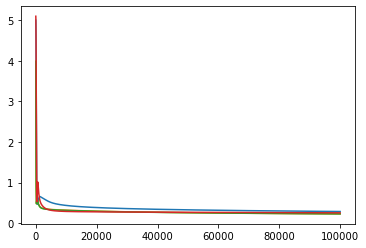

In [477]:
plt.plot(np.linalg.norm(x_mean+2, axis = 1))
plt.plot(np.linalg.norm(na_x_mean+2, axis = 1))
plt.plot(np.linalg.norm(lin_x_mean+2, axis = 1))
plt.plot(np.linalg.norm(DGD_x_mean+2, axis = 1))


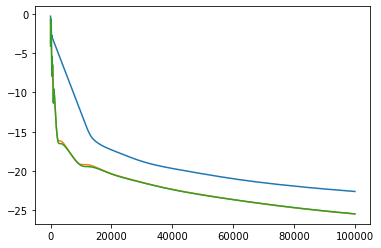

In [478]:
plt.plot(np.log(x_dist[:,2]))
plt.plot(np.log(na_x_dist[:,2]))
plt.plot(np.log(lin_x_dist[:,2]))
# plt.plot(DGD_x_dist[:,2])
# plt.ylim(0,1e-13)

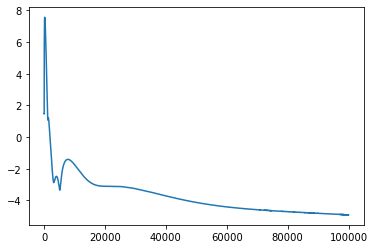

In [435]:
k_range = np.linspace(1, iter_num, iter_num)
# plt.plot(np.log(np.abs(k_range*(x_record-x_mean))))
plt.plot(np.log(np.abs((k_range+1)*(k_range+1)*(x_dist[:,3]))))
# plt.ylim(0,1e-2)

In [433]:
plt.plot(np.log((k_range+1)*np.abs(loss_x_global[:,3])))
# plt.ylim(0,1e-7)

ValueError: operands could not be broadcast together with shapes (1000000,) (100000,) 

Text(0, 0.5, 'log(loss*k^2)')

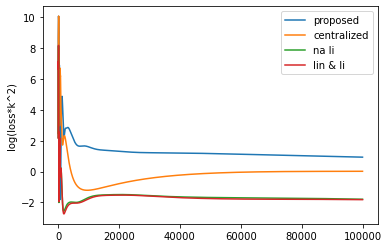

In [480]:
section_size =50000000
plt.plot(np.log((k_range[0:section_size]+1)*(k_range[0:section_size]+1)*(loss_x_global[:section_size,3])), label="proposed")
plt.plot(np.log((k_range[0:section_size]+1)*(k_range[0:section_size]+1)*(DGD_loss_x_global[:section_size,3]-loss_star)), label="centralized")
plt.plot(np.log((k_range[0:section_size]+1)*(k_range[0:section_size]+1)*(na_loss_x_global[:section_size,3]-loss_star)), label="na li")
plt.plot(np.log((k_range[0:section_size]+1)*(k_range[0:section_size]+1)*(lin_loss_x_global[:section_size,3]-loss_star)), label="lin & li")
# plt.ylim(0,1e-1)
# plt.xlim(300,1000)
plt.legend()
plt.ylabel("log(loss*k^2)")


In [341]:
print(np.min(loss_x_global[0:4000]))
print(loss_star)

2.5625050901467716e-05
0


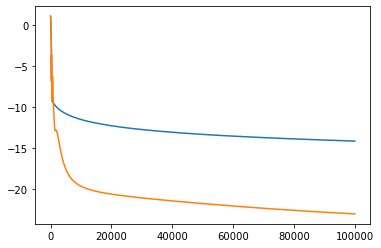

In [342]:
plt.plot(np.log(np.abs(loss_x_global[:,3]-loss_star)))
plt.plot(np.log(np.abs(DGD_loss_x_global[:,3]-loss_star)))

In [255]:
print(np.min(loss_x_global))

1.0663762857743286e-07


(0.0, 5.0)

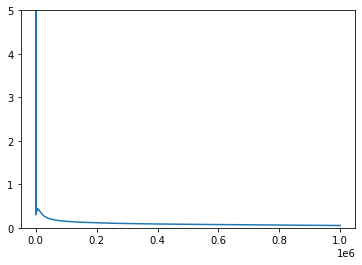

In [430]:
section_size =500000000
plt.plot(((k_range[0:section_size]+1)**2 *(loss_x_global[:section_size,3]-loss_star)))
plt.ylim(0,5)

In [227]:
print(x_k)

[[ 0.03847775 -0.29119031 -0.21288476 -0.25448257]
 [ 0.03847775 -0.2911902  -0.21288475 -0.25448286]
 [ 0.03847789 -0.29119013 -0.2128848  -0.25448306]
 [ 0.0384781  -0.29119011 -0.2128849  -0.25448309]
 [ 0.03847831 -0.29119016 -0.212885   -0.25448293]
 [ 0.03847845 -0.29119027 -0.21288508 -0.25448264]
 [ 0.03847844 -0.29119037 -0.21288509 -0.25448235]
 [ 0.03847831 -0.29119044 -0.21288504 -0.25448216]
 [ 0.03847809 -0.29119046 -0.21288494 -0.25448214]
 [ 0.03847788 -0.29119041 -0.21288483 -0.25448229]]
